In [1]:
from math import pi
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import AdamOptimizer
import datetime
now=datetime.datetime.now

In [2]:
num_qubits=2
dev=qml.device('default.qubit', wires=num_qubits)

In [3]:
# Boundary condition 
coefii = 10

# del_0 = 0  #del
# omega_0 = 0     #w
del_0_v = -1/coefii
omega_0_v = 383.9911/coefii

In [4]:
# Differential equation parameters
ws = 376.9911

# ws = 0.376
# coefii = ws/4
K1 = 5/coefii
K2 = 10/coefii
K3 = 1.7/coefii
ws = ws/coefii

def F_E1(delta_prime, delta,omega_prime,omega, t):       # DE, works with numpy arrays
    return (delta_prime+ws-omega)
    # return X_prime+ws-Y 

def F_E2(delta_prime, delta,omega_prime,omega, t):       # DE, works with numpy arrays
    # return Y_prime
    return omega_prime-K1+K2*np.sin(coefii*delta)+K3*(-ws+omega)*coefii

In [5]:
# # Differential equation's exact solution - for comparison
# def X_t(t):
#     # return X_0_v*np.cos(t)+(3*X_0_v+2*Y_0_v)*np.sin(t)
#     return 0

# def Y_t(t):
#     return 0

In [6]:
t=np.random.uniform(0,1,size=100,requires_grad=False)
print(t)

[0.39478544 0.00974365 0.95391567 0.48954516 0.05474658 0.02757455
 0.6267456  0.07932241 0.14532197 0.29209901 0.12570607 0.97294527
 0.39336152 0.29361321 0.58289872 0.0029323  0.35374677 0.15096709
 0.38427805 0.28897335 0.74738786 0.73498721 0.84322217 0.59493922
 0.33822643 0.52336828 0.65604873 0.11034189 0.81565148 0.98145011
 0.1862946  0.19203264 0.53026397 0.83855058 0.21222548 0.24223366
 0.15618664 0.77698418 0.42634094 0.1108997  0.14199326 0.73977148
 0.60696919 0.05591572 0.14577047 0.65524899 0.94909876 0.7915243
 0.34380937 0.00952788 0.31119599 0.17048345 0.06650748 0.89929812
 0.56842026 0.69457157 0.6744499  0.81571412 0.68119324 0.64732648
 0.94549984 0.08424359 0.43545283 0.62916276 0.49682027 0.47301573
 0.93442205 0.37629788 0.4000272  0.85767832 0.14248193 0.90874719
 0.29586206 0.82395456 0.4311359  0.08693438 0.72045859 0.79991685
 0.40894613 0.89495549 0.1648319  0.72701305 0.32295865 0.45399705
 0.46397558 0.3561226  0.22562008 0.63281643 0.27294522 0.58036

In [7]:
# define embedding layer
def embedding(x,wires):
    qml.RY(x, wires=wires[1])

In [8]:
def Ham():
    obs=[]
    for j in range(num_qubits):
        obs.append(qml.PauliX(j))
        for k in range(j):
            obs.append(qml.PauliZ(j)@qml.PauliZ(k))
    coeffs=np.random.uniform(-1,1,len(obs))*10
    qml.Hamiltonian(coeffs, obs)

In [9]:
# define ansastz layer
def layer(theta):
    
    # Apply Hamiltonian matrix
    Ham()
    
    # Apply H gate
    qml.Hadamard(0)
    
    # rotations on qubit 1
    qml.RY(theta,wires=1)
    
    # CNOT
    qml.CNOT(wires=[0, 1])

In [10]:
@qml.qnode(dev, diff_method="backprop", interface="autograd")
def quantum_net(theta,x):
    
    # encode data
    embedding(x,wires=range(num_qubits))
    
    # parameterized circuit layers
    for v in theta: # (for lool along with the first dimension)
        # print(v)
        # Ham()
        layer(v)
    
    qml.Hadamard(0)
    
    # return qml.expval(qml.PauliZ(0)),qml.expval(qml.PauliZ(1))
    return qml.expval(qml.PauliZ(0))

In [11]:
num_layers=4
theta1=np.random.uniform(0,2*pi,size=(num_layers,num_qubits-1),requires_grad=True)
# theta2=np.random.uniform(0,2*pi,size=(num_layers,num_qubits-1),requires_grad=True)
# theta = np.load('my_theta1.npy')
print(qml.draw(quantum_net)(theta1,0))

0: ──H────────────────╭●──H──────╭●──H──────╭●──H──────╭●──H─┤  <Z>
1: ──RY(0.00)──RY(M0)─╰X──RY(M1)─╰X──RY(M2)─╰X──RY(M3)─╰X────┤     
M0 = 
[1.23390001]
M1 = 
[2.05969796]
M2 = 
[0.79850281]
M3 = 
[5.27823272]


In [12]:
# add the classical layer   #TODO
def classical_quantum_net(theta,w,t):
    r1=quantum_net(theta,t)[0]
    
    return (w[0]+w[1]*r1+w[2]*r1**2,r1)


In [13]:
def classical_quantum_net_prime(theta,w,t,r1):
    # r1=quantum_net(theta,t)[0]
    r1_prime = qml.grad(quantum_net,argnum=1)(theta,np.tensor(t)) 

    return (w[1]*r1_prime+2*w[2]*r1_prime*r1,r1_prime)


In [14]:
def classical_quantum_net_double_prime(theta,w,t,r1,r1_prime):

   # r1=quantum_net(theta,t)[0]
   # r1_prime = qml.grad(quantum_net,argnum=1)(theta,np.tensor(t)) 


   #Calculate double prime
   F_pos_pos_pi = quantum_net(theta,t+np.pi)[0]
   # F_phi = quantum_net(theta,t)[0]
   F_phi = r1
   F_phi_neg_pi = quantum_net(theta,t-np.pi)[0]
   r1_double_prime = (1/4)*(F_pos_pos_pi-2*F_phi+F_phi_neg_pi)


   return w[1]*r1_double_prime+2*w[2]*(r1_prime*r1_prime+r1*r1_double_prime)

In [15]:
def cost_efficient(theta1,w1,t):

    # loss inner points
    loss_i = 0
    del_t_pred = np.zeros(len(t))
    del_t_prime = np.zeros(len(t))
    omega_t_pred = np.zeros(len(t))
    omega_t_prime = np.zeros(len(t))

    for i in range(len(t)):
        res1 = classical_quantum_net(theta=theta1,w=w1,t=t[i])
        del_t_pred[i] = res1[0]._value
        r1 = res1[1]
        res2 = classical_quantum_net_prime(theta=theta1,w=w1,t=t[i],r1=r1)
        del_t_prime[i] = res2[0]._value
        r1_prime = res2[1]
        omega_t_pred[i] = del_t_prime[i]+ws
        omega_t_prime[i] = classical_quantum_net_double_prime(theta=theta1,w=w1,t=t[i],r1=r1,r1_prime=r1_prime)._value

    loss_i += np.mean(F_E1(delta=del_t_pred,omega=omega_t_pred,delta_prime=del_t_prime,omega_prime=omega_t_prime,t=t)**2)
    loss_i += np.mean(F_E2(delta=del_t_pred,omega=omega_t_pred,delta_prime=del_t_prime,omega_prime=omega_t_prime,t=t)**2)

    # # loss boundary points
    loss_b = 0
    ress = classical_quantum_net(theta1,w1,0)
    del_0_pred = ress[0]
    # del_0_pred = del_t_pred[0]
    ress2 = classical_quantum_net_prime(theta1,w1,0,r1=ress[1])
    omega_0_pred = ress2[0]+ws
    # omega_0_pred = omega_t_pred[0]
    

    # # print(U_0)
    loss_b += (del_0_v-del_0_pred)**2+(omega_0_v-omega_0_pred)**2
    return loss_b + loss_i
    # return 0.2*loss_b + 0.8*loss_i

    return loss_i

In [16]:
# def cost(theta1,w1,t):

#     # loss inner points
#     loss_i = 0

#     del_t_pred = np.array([classical_quantum_net(theta=theta1,w=w1,t=point) for point in t])
#     del_t_prime = np.array([classical_quantum_net_prime(theta=theta1,w=w1,t=point) for point in t])
    
#     omega_t_pred = del_t_prime+ws
#     # Y_t_prime = np.array([classical_quantum_net_prime(theta=theta2,w=w2,t=point) for point in t])
#     omega_t_prime = np.array([classical_quantum_net_double_prime(theta=theta1,w=w1,t=point) for point in t])

#     loss_i += np.mean(F_E1(delta=del_t_pred,omega=omega_t_pred,delta_prime=del_t_prime,omega_prime=omega_t_prime,t=t)**2)
#     loss_i += np.mean(F_E2(delta=del_t_pred,omega=omega_t_pred,delta_prime=del_t_prime,omega_prime=omega_t_prime,t=t)**2)

#     # # loss boundary points
#     loss_b = 0
#     del_0_pred = classical_quantum_net(theta1,w1,0)
#     omega_0_pred = classical_quantum_net_prime(theta1,w1,0)+ws

#     # # print(U_0)
#     loss_b += (del_0_v-del_0_pred)**2+(omega_0_v-omega_0_pred)**2
#     return loss_b + loss_i
#     # return 0.2*loss_b + 0.8*loss_i

#     return loss_i

In [17]:
w1=np.zeros(3,requires_grad=True)
# w2=np.zeros(3,requires_grad=True)
opt = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)

In [18]:
start=now()
print(start)

2023-08-11 19:11:24.762101


In [19]:
epochs=100
cost_max = 10000
theta1_best = None
w1_best = None

for e in range(1,epochs+1):

    # (theta1,theta2,w1,w2,_),_cost=opt.step_and_cost(cost,theta1,theta2,w1,w2,t)
    (theta1,w1,_),_cost=opt.step_and_cost(cost_efficient,theta1,w1,t)

    if _cost<cost_max:
        cost_max = _cost
        theta1_best = theta1
        w1_best = w1

    # (theta,_),_cost=opt.step_and_cost(cost,theta,t)
    if e==1 or e%1==0:
        print(f'Epoch: {e} | Cost: {_cost}')

Epoch: 1 | Cost: 0.749999999999994
Epoch: 2 | Cost: 0.9748561419340988
Epoch: 3 | Cost: 1.0402138775942444
Epoch: 4 | Cost: 0.8878444390168223
Epoch: 5 | Cost: 0.702733357946576
Epoch: 6 | Cost: 0.6296509872149423
Epoch: 7 | Cost: 0.6735015095154413
Epoch: 8 | Cost: 0.726173982599488
Epoch: 9 | Cost: 0.7981871568109526
Epoch: 10 | Cost: 1.0615865328297522
Epoch: 11 | Cost: 1.319273426264693
Epoch: 12 | Cost: 1.3934234860578856
Epoch: 13 | Cost: 1.4611916892288688
Epoch: 14 | Cost: 1.5686420925087414
Epoch: 15 | Cost: 1.6532405731147866
Epoch: 16 | Cost: 1.6863986988226698
Epoch: 17 | Cost: 1.6883773577177414
Epoch: 18 | Cost: 1.673646197534951
Epoch: 19 | Cost: 1.6384448414737611
Epoch: 20 | Cost: 1.5841671038046379
Epoch: 21 | Cost: 1.5226163953574448
Epoch: 22 | Cost: 1.4708760219669519
Epoch: 23 | Cost: 1.4409529299312092
Epoch: 24 | Cost: 1.4314409573239026
Epoch: 25 | Cost: 1.431816950921793
Epoch: 26 | Cost: 1.4305039229560694
Epoch: 27 | Cost: 1.421230547508063
Epoch: 28 | Cost:

In [20]:
# print(_cost)
t=np.random.uniform(0,1,size=100,requires_grad=False)

pred_train_X=np.array([classical_quantum_net(theta1,w1,t) for t in t])
pred_train_Y=(np.array([classical_quantum_net_prime(theta1,w1,t) for t in t])+ws)
print(pred_train_X)
print(pred_train_Y)
# pred_train_Y=np.array([classical_quantum_net(theta2,w2,t) for t in t])

TypeError: classical_quantum_net_prime() missing 1 required positional argument: 'r1'

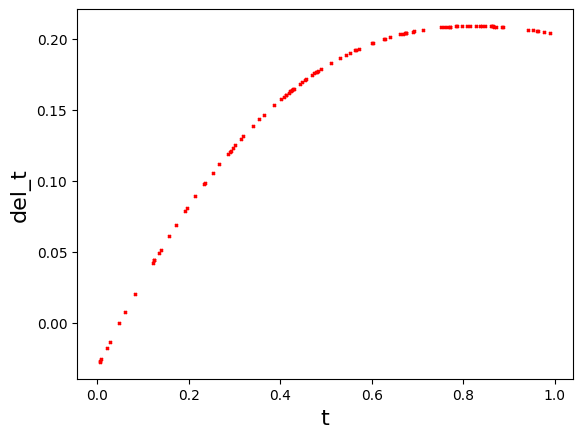

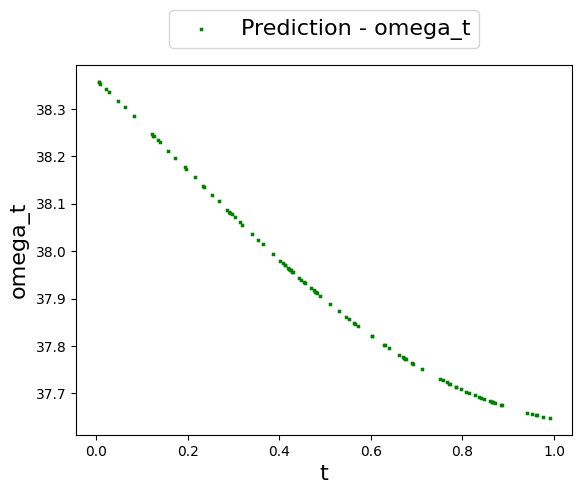

In [ ]:
plt.figure()
# plt.scatter(t,X_t(t),facecolors='none', edgecolors='r', label='True - X_t')
plt.scatter(t,pred_train_X, color='red',marker="x",s=4,label='Prediction - del_t')
plt.xlabel('t',fontsize=16)
plt.ylabel('del_t',fontsize=16)
# plt.scatter(t,Y_t(t),facecolors='none', edgecolors='g', label='True - Y_t')
plt.figure()
plt.scatter(t,pred_train_Y, color='green',marker="x",s=4,label='Prediction - omega_t')

plt.xlabel('t',fontsize=16)
plt.ylabel('omega_t',fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper center',bbox_to_anchor=(0.5,1.18),ncol=2,fontsize=16)
# plt.savefig('1_measurement2_train.png')
plt.show()